# Imports

In [1]:
import os
import glob
import json
import ast
import re

from typing import Dict, List

from src.utils.parsers.cv_parser import fmt_cv_results
from src.utils.visualizers.prediction_figures import PredictionFigures
from src.utils.visualizers.test_figures import TestFigures
from src.utils.visualizers.cv_figures import CVFigures

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, kendalltau

# Utils

In [2]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

In [3]:
metabolite_info = get_metabolite_info()

# Experiments

## Experiment base (TIER0)

In [4]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"
test_df_all = pd.read_csv(
    f'{dir}/best_model_performance_Strategy.ALL.csv',
    index_col=0
)
test_df_all = test_df_all.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df_all = test_df_all.merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='all')

test_df_metabolite = pd.read_csv(
    f'{dir}/best_model_performance.csv',
    index_col=0
)
test_df_metabolite = test_df_metabolite.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df_metabolite = test_df_metabolite.merge(metabolite_info, left_on='metabolite_id', right_index=True).assign(strategy='metabolite')

test_df = pd.concat([test_df_all, test_df_metabolite], axis=0)
test_figures = TestFigures(test_df)

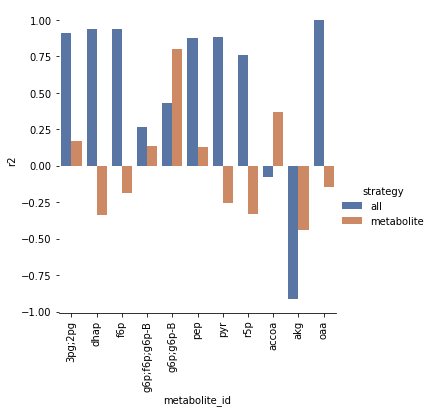

In [5]:
# plt.figure(figsize=(4, 1))
test_figures.r2_per_tier()

### Strategy all

In [6]:
def gather_results_throttle(paths: List[str]):
    throttle_coefficients = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('best_model_performance_Strategy.ALL_throttle') for path in paths]
    print(paths)
    df = pd.concat([
        pd.read_csv(path, index_col=0).stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1).assign(throttle=throttle) 
        for path, throttle in zip(paths, throttle_coefficients)
    ])
    return df

def gather_results_throttle_v2(paths: List[str]):
    throttle_coefficients = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('best_model_performance_Strategy.ALL_throttle').split("__") for path in paths]
    throttle_list = [(throttle, run_id.strip("run")) for throttle, run_id in throttle_coefficients]
    # print(throttle_list)
    df = pd.concat([
        pd.read_csv(path, index_col=0).stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1).assign(throttle=throttle).assign(run_id=run_id)
        for path, (throttle, run_id) in zip(paths, throttle_list)
    ])
    return df

In [7]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"
df = pd.read_csv(f'{dir}/Strategy.ALL_all.csv')
df = fmt_cv_results(df)

test_df = pd.read_csv(
    f'{dir}/best_model_performance_Strategy.ALL.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

# test_throttle_df = gather_results_throttle(glob.glob(dir + "/throttle/best_model*Strategy.ALL*.csv"))
# test_throttle_df = test_throttle_df.sort_values('throttle').merge(metabolite_info, left_on='metabolite_id', right_index=True).reset_index().drop('index', axis=1)

test_throttle_df = gather_results_throttle_v2(glob.glob(dir + "/throttle/best_model*Strategy.ALL*_run*.csv"))
test_throttle_df = test_throttle_df.sort_values('throttle').merge(metabolite_info, left_on='metabolite_id', right_index=True).reset_index().drop('index', axis=1)
# test_throttle_df.reset_index().drop('index', axis=1)

explanation_df = pd.read_json(f'{dir}/explanations/Strategy.ALL_explanation.json').merge(metabolite_info, left_on='metabolite_id', right_index=True)

#### Explanation analysis
1. How many different enzymes are found important per metabolites/pathway
2. Is there a relationship within a metabolite between the different explenations
3. Do we need to account for exp weight

In [34]:
explanation_df

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred,official_name,kegg_id,pathway,method,Order
0,YKL025C,dhap,"[YER012W, YAL007C, YBR035C, YDR368W, YPR062W, ...","[-0.018561471700000002, -0.0157815406, -0.0140...",0.589346,0.962289,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
15,YER129W,dhap,"[YER012W, YOR280C, YML008C, YGR155W, YGL087C, ...","[-0.01730261, -0.0166238608, -0.01512136720000...",0.832151,1.137783,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
18,YDR122W,dhap,"[YER012W, YAL007C, YOR261C, YML008C, YNL241C, ...","[-0.0166590182, -0.014732039700000001, -0.0142...",-0.296094,-0.487018,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
22,YPL026C,dhap,"[YOR280C, YBR035C, YOR261C, YNL287W, YOR332W, ...","[-0.0177926971, -0.0144371311, -0.0131263781, ...",0.759479,0.963042,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
31,YPR111W,dhap,"[YER012W, YOR280C, YFR010W, YLR354C, YGL026C, ...","[-0.017085505600000002, -0.0160274091, 0.01184...",0.612752,0.603898,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
...,...,...,...,...,...,...,...,...,...,...,...
73,YBR097W,akg,"[YHR174W, YGR254W, YGL256W, YDR533C, YDR516C, ...","[0.0134242219, 0.012936393000000001, 0.0117870...",-0.016738,-1.646500,2-Oxoglutarate,C00026,TCA,TCA,4
129,YPL141C,akg,"[YOR280C, YGR254W, YML008C, YLR438W, YBR249C, ...","[-0.0202458092, 0.014839534900000001, -0.01341...",-0.126592,0.597181,2-Oxoglutarate,C00026,TCA,TCA,4
57,YHR082C,oaa,"[YOR280C, YDR019C, YFR010W, YLR438W, YER062C, ...","[-0.0185947675, 0.0159936983, 0.0141979957, 0....",-0.349152,-0.273203,Oxaloacetate,C00036,TCA,TCA,8
80,YDR490C,oaa,"[YER012W, YDR234W, YML008C, YGR175C, YGL255W, ...","[-0.019756548000000002, 0.0141105484, -0.01409...",-0.378997,0.032656,Oxaloacetate,C00036,TCA,TCA,8


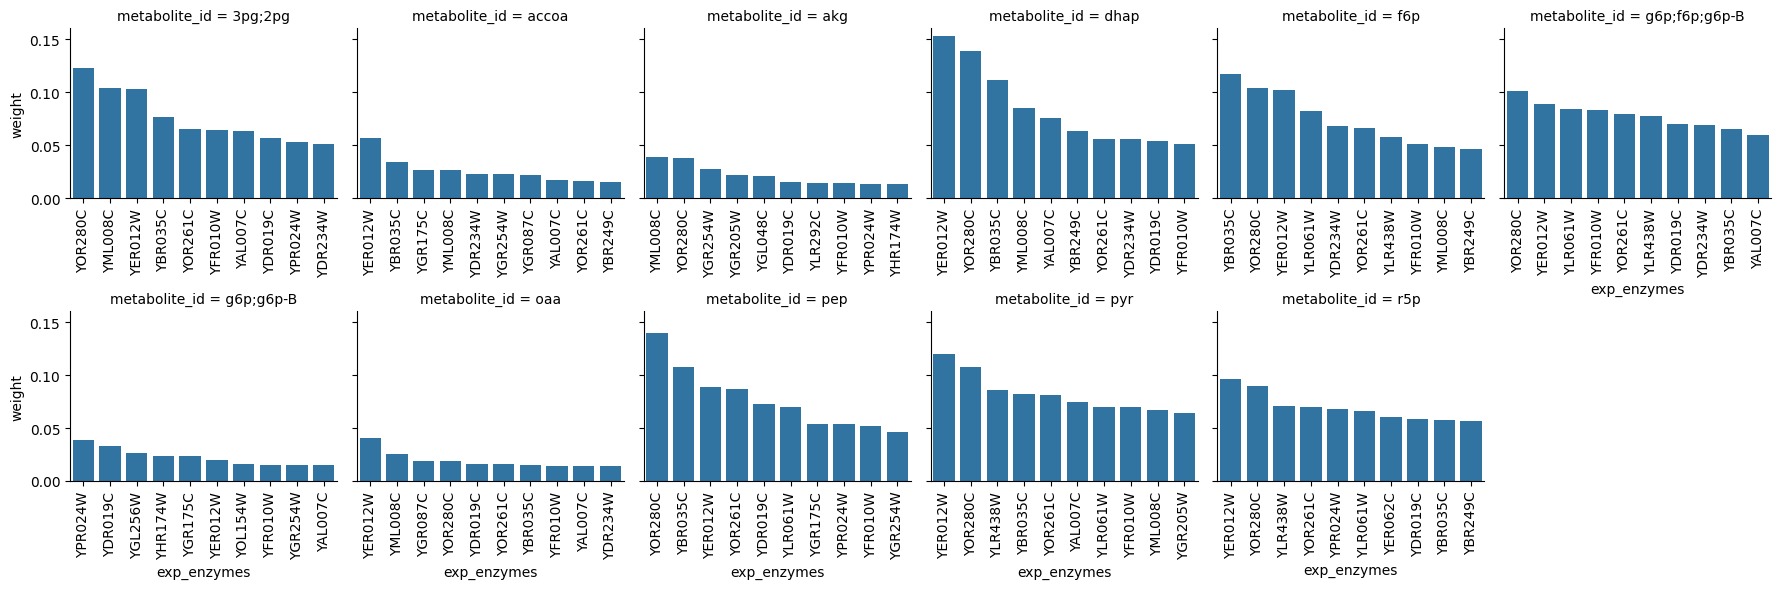

In [9]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']).groupby(by=['metabolite_id', 'exp_enzymes'])['exp_weights'].sum().abs() \
    .to_frame('weight').reset_index() \
    .groupby('metabolite_id').apply(lambda x: x.sort_values(by='weight', ascending=False).head(10))

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='weight')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

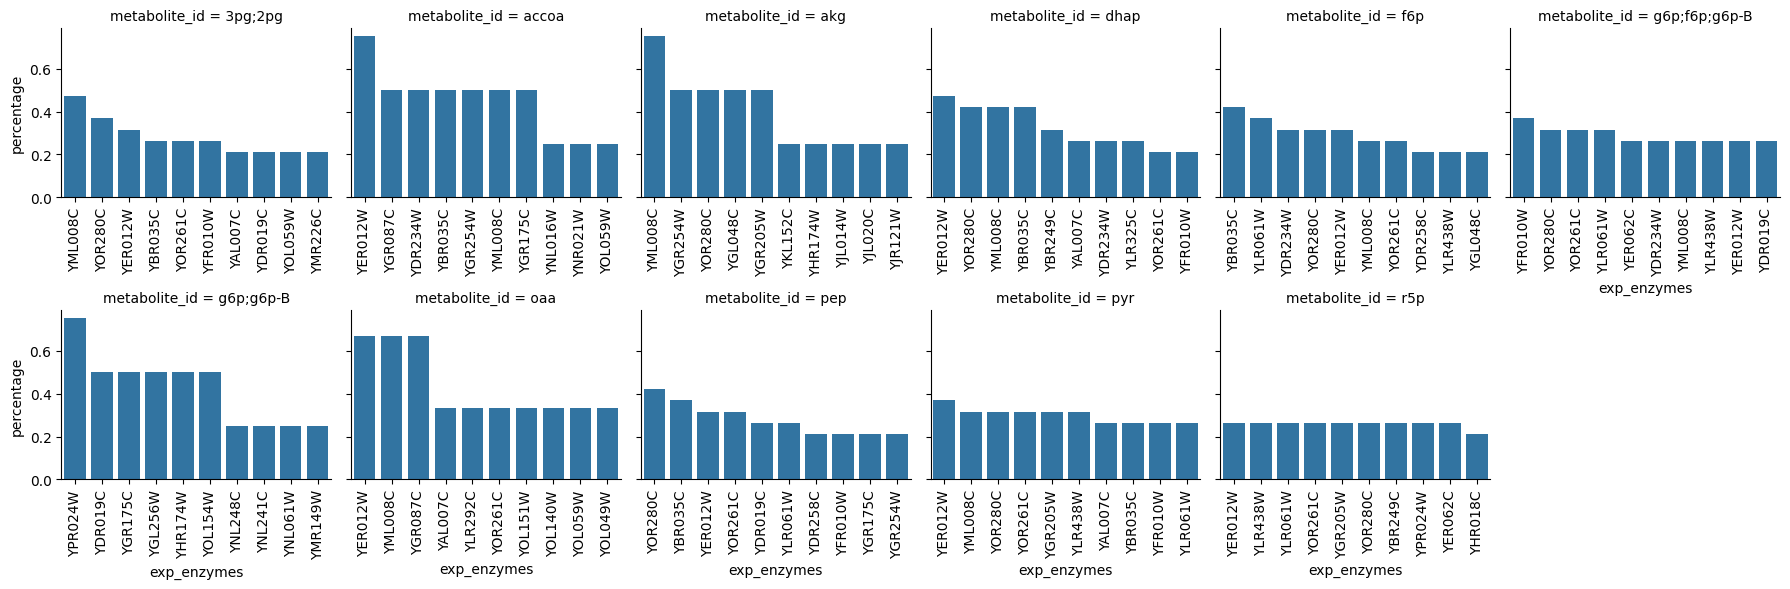

In [33]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['metabolite_id', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('metabolite_id', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('metabolite_id').size().to_frame('total'),
    left_on='metabolite_id',
    right_on='metabolite_id'
)
_df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='percentage')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

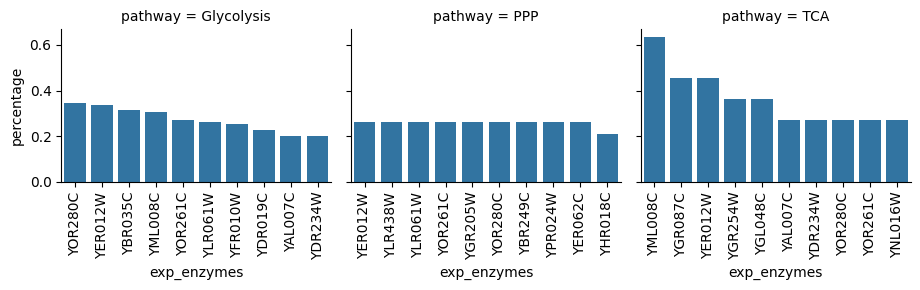

In [37]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['pathway', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('pathway', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('pathway').size().to_frame('total'),
    left_on='pathway',
    right_on='pathway'
)
_df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='pathway', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='percentage')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

In [ ]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights']) 

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.boxplot, x='exp_enzymes', y='exp_weights')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

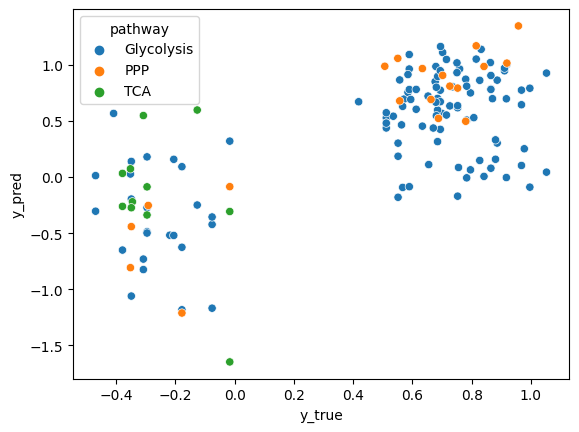

In [9]:
sns.scatterplot(
    data=explanation_df,
    x='y_true',
    y='y_pred',
    hue='pathway',
)

<AxesSubplot:xlabel='exp_enzymes', ylabel='count'>

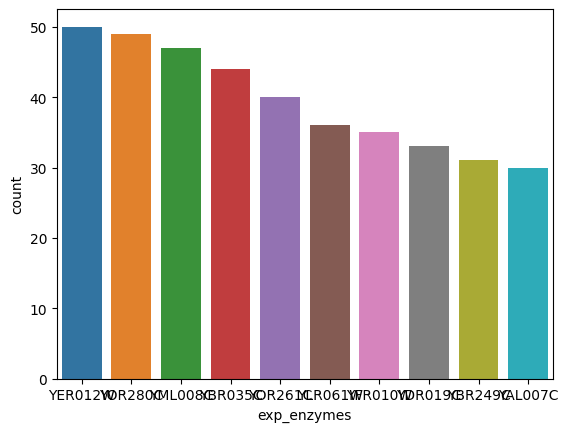

In [13]:
_df = explanation_df.explode(['exp_enzymes', 'exp_weights'])
sns.countplot(
    data=_df,
    x='exp_enzymes',
    order=_df['exp_enzymes'].value_counts().iloc[:10].index
)

In [27]:
explanation_df.explode(['exp_enzymes', 'exp_weights']).groupby(by='metabolite_id')['exp_enzymes'].unique()

metabolite_id
3pg;2pg          [YER012W, YML008C, YGL255W, YOR261C, YPL143W, ...
accoa            [YHR174W, YJL020C, YGL256W, YDR533C, YDR127W, ...
akg              [YOR280C, YFR010W, YML008C, YGR001C, YGL048C, ...
dhap             [YER012W, YAL007C, YBR035C, YDR368W, YPR062W, ...
f6p              [YER012W, YLR438W, YBR035C, YPR024W, YLR061W, ...
g6p;f6p;g6p-B    [YER012W, YOR280C, YAL007C, YDR234W, YDR127W, ...
g6p;g6p-B        [YGR254W, YDR533C, YLR061W, YGL256W, YHR174W, ...
oaa              [YOR280C, YDR019C, YFR010W, YLR438W, YER062C, ...
pep              [YDR019C, YAL007C, YGR175C, YIL063C, YPR024W, ...
pyr              [YOR280C, YLR061W, YDR019C, YFR010W, YJL171C, ...
r5p              [YBR035C, YAL007C, YFR010W, YPR024W, YDR427W, ...
Name: exp_enzymes, dtype: object

#### Throttle analysis

[(0.1, 9.0)]

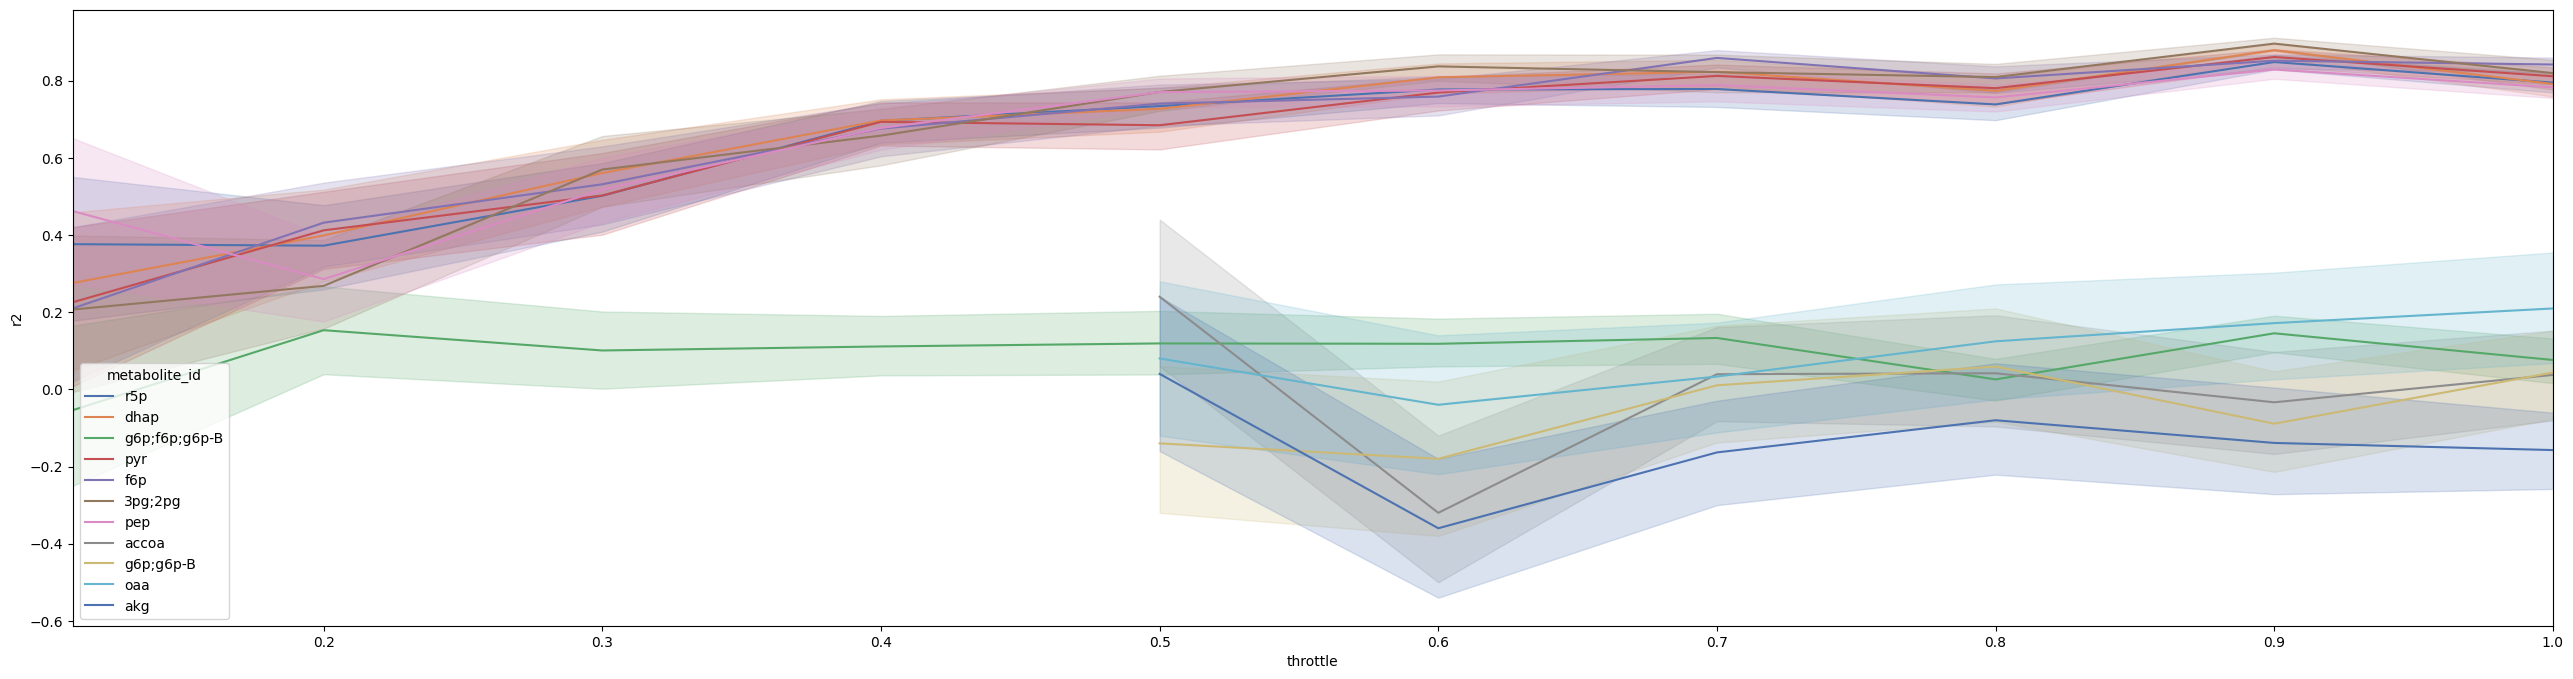

In [8]:
g = sns.lineplot(
    data=test_throttle_df,
    x='throttle',
    y='r2',
    hue='metabolite_id',
    palette='deep',
)
g.set(xlim=(0.1, 9.0))

In [9]:
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

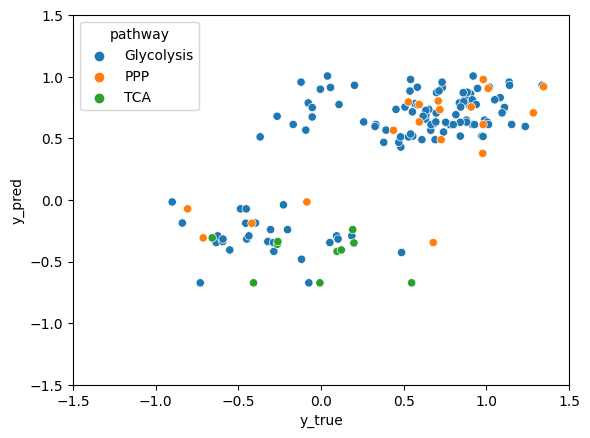

In [10]:
pred_figures.prediction_per_pathway_all()

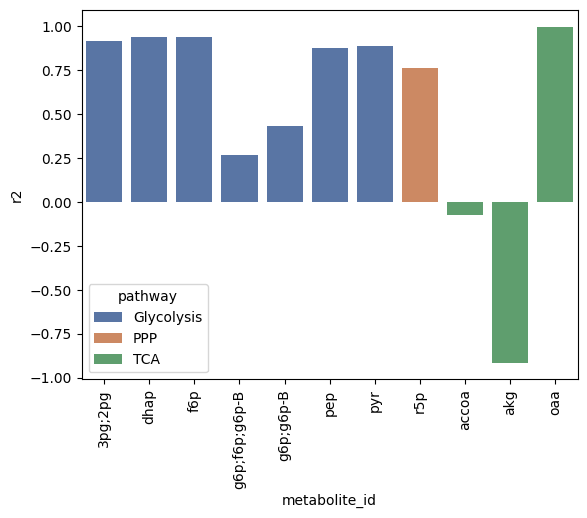

In [11]:
test_figures.r2_per_metabolite()

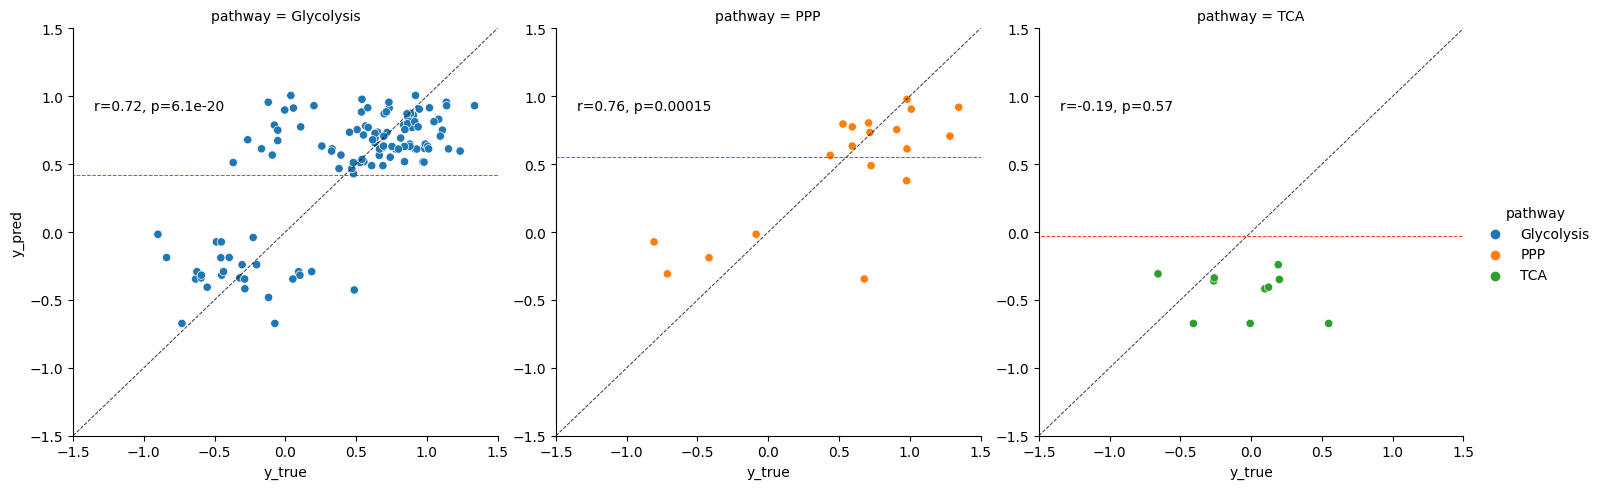

In [12]:
pred_figures.prediction_per_pathway_individual()

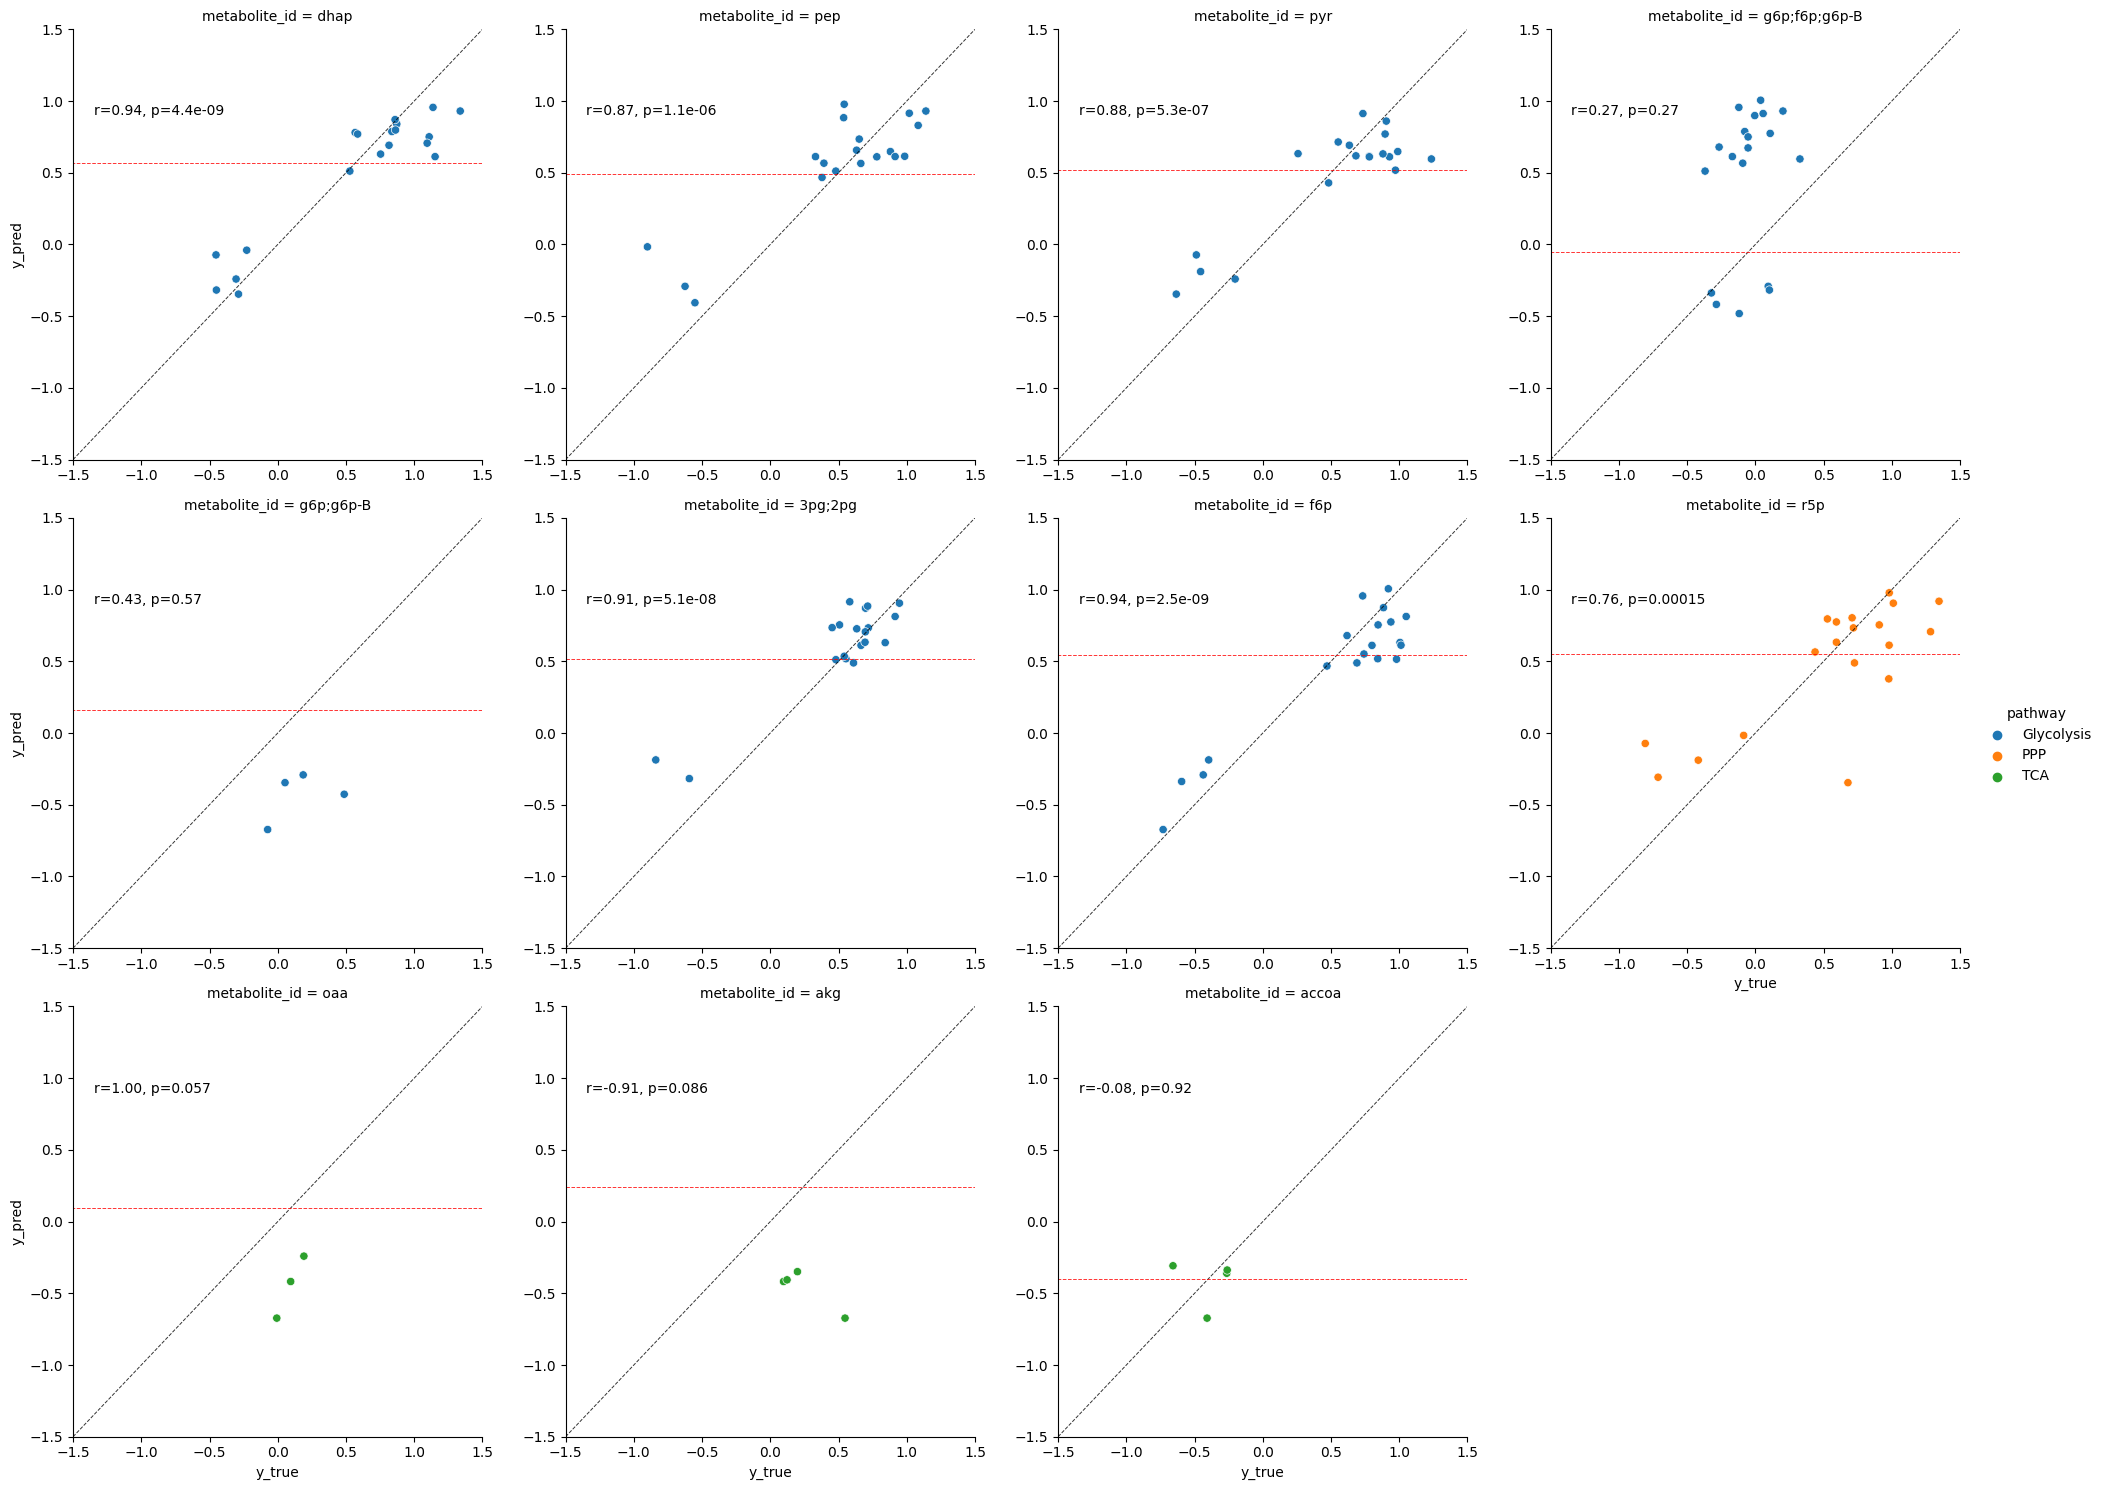

In [13]:
pred_figures.prediction_per_metabolite_individual()

### Strategy metabolic

In [ ]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"
paths = glob.glob(dir + "/Strategy.METABOLITE_CENTRIC*.csv")

df = gather_results(paths)
df = fmt_cv_results(df)
df = combine_metabolite_info(df)

test_df = pd.read_csv(
    f'{dir}/best_model_performance.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

cv_fgures = CVFigures(df)
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

In [ ]:
cv_fgures.cv_results()

In [ ]:
test_figures.r2_per_metabolite()

In [ ]:
pred_figures.prediction_per_pathway_all()

In [ ]:
pred_figures.prediction_per_pathway_individual()

In [ ]:
pred_figures.prediction_per_metabolite_individual()

## Experiments simple baseline (TIER 1)

### Strategy all

In [ ]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_1"
df = pd.read_csv(f'{dir}/Strategy.ALL_all.csv')
df = fmt_cv_results(df)
df

In [ ]:
test_df = pd.read_csv(
    f'{dir}/best_model_performance_Strategy.ALL.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)

test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])

In [ ]:
pred_figures = PredictionFigures(test_pred_df)
test_figures = TestFigures(test_df)

In [ ]:
pred_figures.prediction_per_pathway_all()

In [ ]:
test_figures.r2_per_metabolite()

In [ ]:
pred_figures.prediction_per_pathway_individual()

In [ ]:
pred_figures.prediction_per_metabolite_individual()